In [43]:
# Spatial Transcriptomic Data Analysis Tutorial
# Clustering in Detail
# This script is try and optimize different clustering methods


# Example Data:
# Hepatocellular carcinoma (HCC) resection specimens
# Publication link: https://pubmed.ncbi.nlm.nih.gov/37723590/

# By: Ashok K. Sharma
# Date: 11-18-2024

In [44]:
# Libraries
#!pip3 install louvain
import scanpy as sc
from sklearn.cluster import KMeans # For Clustering

import warnings
warnings.filterwarnings("ignore")

In [45]:
# Load Ann Data Object
adata = sc.read('data/GSE238264_AnnDataObject.h5ad') # Load the Data Again

# To divide Samples in to the Group - Note: This step needs to be sutomized based on the Sample Names and metadata
# Sample names ends with NR are NonResponder and R are Responder
# Add a new column 'response_category' to classify each sample
adata.obs['response_category'] = adata.obs['sample'].apply(
    lambda x: 'NonResponder' if x.endswith('NR') else 'Responder'
)

# Check to ensure the new column is added and categories are correct
print(adata.obs[['sample', 'response_category']].head())

                           sample response_category
AAACAGAGCGACTCCT-1-HCC5NR  HCC5NR      NonResponder
AAACAGCTTTCAGAAG-1-HCC5NR  HCC5NR      NonResponder
AAACAGGGTCTATATT-1-HCC5NR  HCC5NR      NonResponder
AAACCGGGTAGGTACC-1-HCC5NR  HCC5NR      NonResponder
AAACCTCATGAAGTTG-1-HCC5NR  HCC5NR      NonResponder


In [46]:
# Normalize total counts to 10,000 per cell
combined_ad = adata # Store adata in combined_ad
sc.pp.normalize_total(combined_ad, target_sum=1e4)

# Logarithmize the data
sc.pp.log1p(combined_ad)

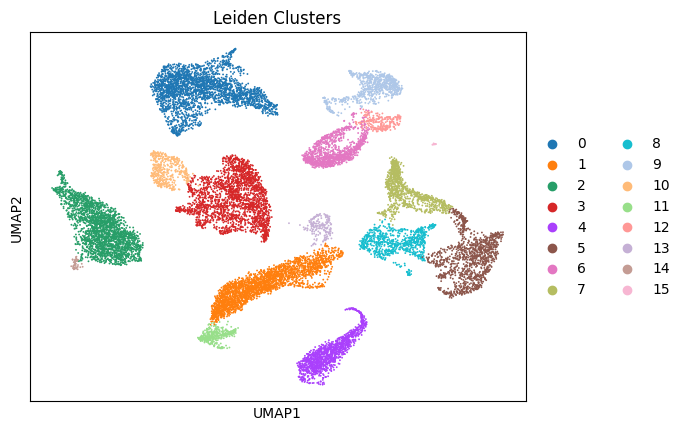

leiden  sample
0       HCC6NR    2574
        HCC5NR       0
        HCC2R        0
        HCC1R        0
        HCC7NR       0
                  ... 
15      HCC6NR       0
        HCC2R        0
        HCC7NR       0
        HCC3R        0
        HCC4R        0
Name: sample, Length: 112, dtype: int64


In [47]:
# Step1: 1. Quantify Clustering Behavior
sc.tl.pca(combined_ad, svd_solver='arpack')  # PCA --> 'arpack' or 'randomized'
sc.pp.neighbors(combined_ad, n_neighbors=10, n_pcs=40)  # You can adjust n_neighbors and n_pcs
sc.tl.umap(combined_ad) # UMAP -->

# a. Assign Clusters
sc.tl.leiden(combined_ad, resolution=0.5)

#b. Plot Cluster Distributions
#sc.pl.spatial(combined_ad, color='leiden', size=1.5, title="Leiden Clusters")
sc.pl.umap(combined_ad, color='leiden', title='Leiden Clusters', show=True) # Using Clusters

#c. Analyze Cluster Composition
cluster_counts = combined_ad.obs.groupby('leiden')['sample'].value_counts()
print(cluster_counts)
cluster_counts_df = cluster_counts.reset_index(name='count') # Convert to a DataFrame for saving
cluster_counts_df.to_csv('data/cluster_counts.csv', index=False) # Save the DataFrame to a CSV file

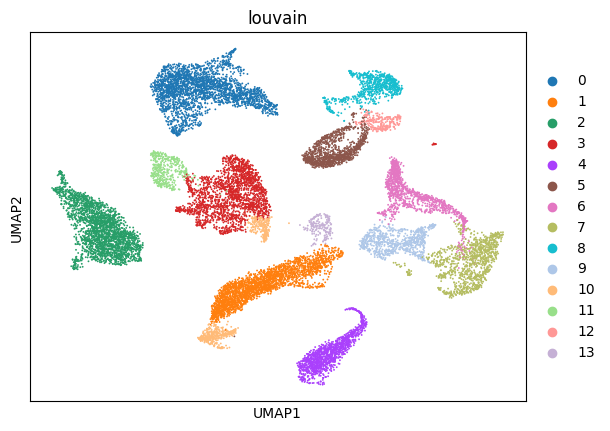

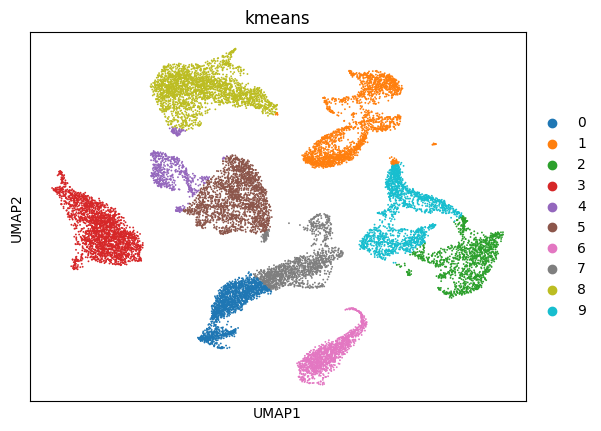

Cluster count data has been saved to 'data/combined_cluster_counts.csv'
ARI and NMI between leiden and kmeans
ARI: 0.7984971651462994, NMI: 0.8747852592541282
ARI and NMI between louvain and kmeans
ARI: 0.7862989028727099, NMI: 0.8618534815624881
ARI and NMI between louvain and leiden
ARI: 0.9567982291121225, NMI: 0.9606076504955509


In [51]:
# Step2:. Compare Different Clusterings
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import pandas as pd

# Louvain Clustering
sc.tl.louvain(combined_ad, resolution=0.5)
sc.pl.umap(combined_ad, color='louvain')

# KMeans Clustering
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=42).fit(combined_ad.obsm['X_umap'])
combined_ad.obs['kmeans'] = kmeans.labels_.astype(str)
sc.pl.umap(combined_ad, color='kmeans')

#b. Compare Clustering Results
# Analyze Cluster Composition
leiden_cluster_counts = combined_ad.obs.groupby('leiden')['sample'].value_counts()
leiden_df = leiden_cluster_counts.reset_index(name='leiden_count') # Convert in data frame
louvain_cluster_counts = combined_ad.obs.groupby('louvain')['sample'].value_counts()
louvain_df = louvain_cluster_counts.reset_index(name='louvain_count') # Convert in data frame
kmeans_cluster_counts = combined_ad.obs.groupby('kmeans')['sample'].value_counts()
kmeans_df = kmeans_cluster_counts.reset_index(name='kmeans_count') # Convert in data frame
# Merge the DataFrames on 'sample' and clustering identifiers
combined_df = pd.merge(
    leiden_df, 
    louvain_df, 
    on=['sample'], 
    how='outer', 
    suffixes=('_leiden', '_louvain')
)
combined_df = pd.merge(
    combined_df, 
    kmeans_df, 
    on=['sample'], 
    how='outer', 
    suffixes=('', '_kmeans')
)
# Save the combined DataFrame to a CSV file
combined_df.to_csv('data/combined_cluster_counts.csv', index=False)
print("Cluster count data has been saved to 'data/combined_cluster_counts.csv'")

#Calculate agreement between clusterings using the Adjusted Rand Index (ARI) or Normalized Mutual Information (NMI):
# Between leiden and kmeans
ari = adjusted_rand_score(combined_ad.obs['leiden'], combined_ad.obs['kmeans'])
nmi = normalized_mutual_info_score(combined_ad.obs['leiden'], combined_ad.obs['kmeans'])
print("ARI and NMI between leiden and kmeans")
print(f"ARI: {ari}, NMI: {nmi}")

# Between louvain and kmeans
ari = adjusted_rand_score(combined_ad.obs['louvain'], combined_ad.obs['kmeans'])
nmi = normalized_mutual_info_score(combined_ad.obs['louvain'], combined_ad.obs['kmeans'])
print("ARI and NMI between louvain and kmeans")
print(f"ARI: {ari}, NMI: {nmi}")

# Between louvain and kmeans
ari = adjusted_rand_score(combined_ad.obs['louvain'], combined_ad.obs['leiden'])
nmi = normalized_mutual_info_score(combined_ad.obs['louvain'], combined_ad.obs['leiden'])
print("ARI and NMI between louvain and leiden")
print(f"ARI: {ari}, NMI: {nmi}")

#Adjusted Rand Index (ARI): Measures the similarity between two clusterings while adjusting for chance. It quantifies how well clusters match true labels or other clustering results, focusing on correct pairwise assignments.
#Normalized Mutual Information (NMI): Measures the amount of shared information between two clusterings, normalized to account for differences in cluster size and number. It evaluates how well one clustering predicts the other.

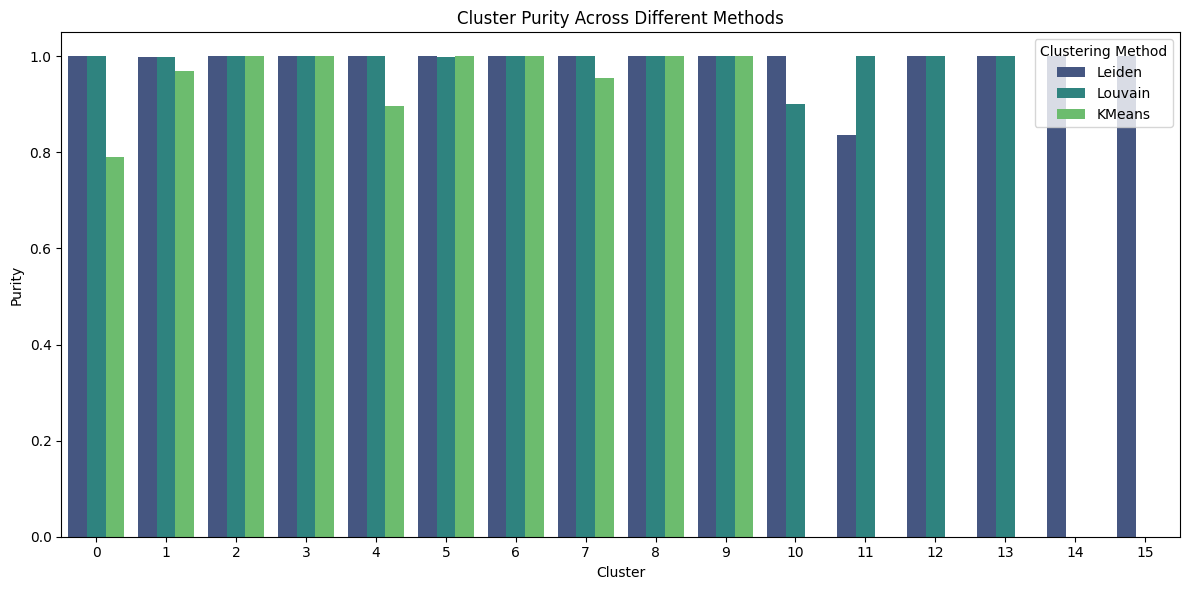

Cluster Purity Summary:
Leiden Overall Purity: 0.99
Louvain Overall Purity: 0.99
KMeans Overall Purity: 0.96

Cluster-Wise Purity Details:
   cluster    purity   method
0        0  1.000000   Leiden
1        1  0.998442   Leiden
2        2  1.000000   Leiden
3        3  1.000000   Leiden
4        4  1.000000   Leiden
5        5  1.000000   Leiden
6        6  1.000000   Leiden
7        7  1.000000   Leiden
8        8  1.000000   Leiden
9        9  1.000000   Leiden
10      10  1.000000   Leiden
11      11  0.836272   Leiden
12      12  1.000000   Leiden
13      13  1.000000   Leiden
14      14  1.000000   Leiden
15      15  1.000000   Leiden
16       0  1.000000  Louvain
17       1  0.998054  Louvain
18       2  1.000000  Louvain
19       3  1.000000  Louvain
20       4  1.000000  Louvain
21       5  0.999136  Louvain
22       6  1.000000  Louvain
23       7  1.000000  Louvain
24       8  1.000000  Louvain
25       9  1.000000  Louvain
26      10  0.900631  Louvain
27      11  1.000000 

In [53]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Function to compute cluster purity for a given method
def compute_cluster_purity(adata, method):
    cluster_purity = (
        adata.obs.groupby(method)['sample']
        .value_counts(normalize=True)
        .groupby(level=0)
        .max()
    )
    overall_purity = cluster_purity.mean()
    return cluster_purity, overall_purity

# Compute cluster purities for all methods
leiden_purity, leiden_overall = compute_cluster_purity(combined_ad, 'leiden')
louvain_purity, louvain_overall = compute_cluster_purity(combined_ad, 'louvain')
kmeans_purity, kmeans_overall = compute_cluster_purity(combined_ad, 'kmeans')

# Combine purities into a single DataFrame for plotting
purity_df = pd.concat([
    pd.DataFrame({'cluster': leiden_purity.index, 'purity': leiden_purity.values, 'method': 'Leiden'}),
    pd.DataFrame({'cluster': louvain_purity.index, 'purity': louvain_purity.values, 'method': 'Louvain'}),
    pd.DataFrame({'cluster': kmeans_purity.index, 'purity': kmeans_purity.values, 'method': 'KMeans'}),
], ignore_index=True)

# Plot cluster purity comparison
plt.figure(figsize=(12, 6))
sns.barplot(
    data=purity_df, 
    x='cluster', 
    y='purity', 
    hue='method', 
    palette='viridis'
)
plt.title('Cluster Purity Across Different Methods')
plt.xlabel('Cluster')
plt.ylabel('Purity')
plt.legend(title='Clustering Method')
plt.tight_layout()
plt.show()

# Print summary stats for all methods
print("Cluster Purity Summary:")
print(f"Leiden Overall Purity: {leiden_overall:.2f}")
print(f"Louvain Overall Purity: {louvain_overall:.2f}")
print(f"KMeans Overall Purity: {kmeans_overall:.2f}")

# Print purity data for clusters
print("\nCluster-Wise Purity Details:")
print(purity_df)

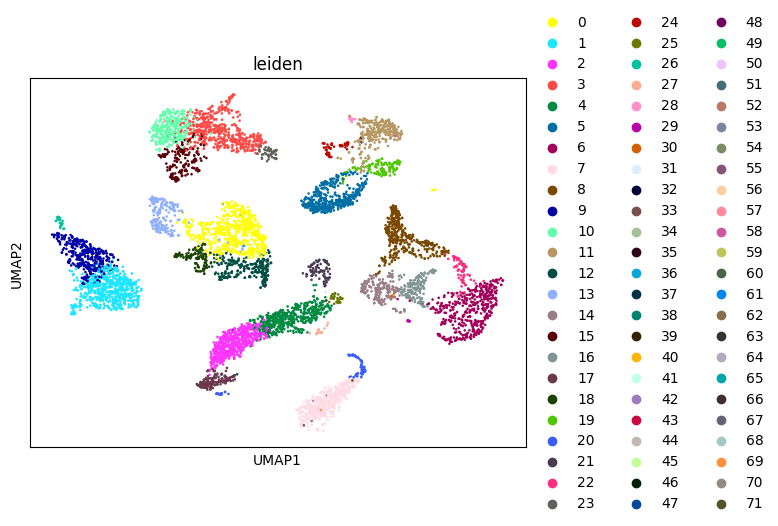

In [54]:
# Step3:. Evaluate Cluster Stability
# a. Random Subsampling
#Downsample the dataset and recluster to check consistency.
import scanpy as sc
from sklearn.utils import resample

# Subsample data
adata_subsampled = combined_ad[resample(range(combined_ad.n_obs), n_samples=combined_ad.n_obs // 2)]

# Reclustering
sc.tl.leiden(adata_subsampled, resolution=0.5)
sc.pl.umap(adata_subsampled, color='leiden')

#b. Bootstrap Analysis
#Perform bootstrap clustering and assess consistency across iterations:
from collections import Counter

bootstrap_results = []
for _ in range(10):  # 10 bootstrap iterations
    adata_bootstrap = combined_ad[resample(range(combined_ad.n_obs), n_samples=combined_ad.n_obs)]
    sc.tl.leiden(adata_bootstrap, resolution=0.5)
    bootstrap_results.append(adata_bootstrap.obs['leiden'])

# Count clustering consistency
cluster_agreement = Counter([tuple(row) for row in zip(*bootstrap_results)])
#print(cluster_agreement)

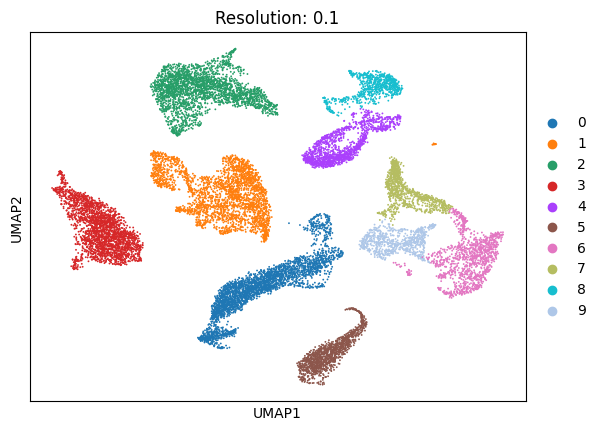

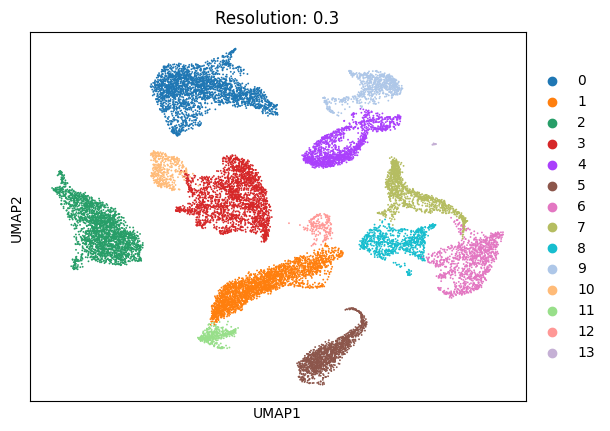

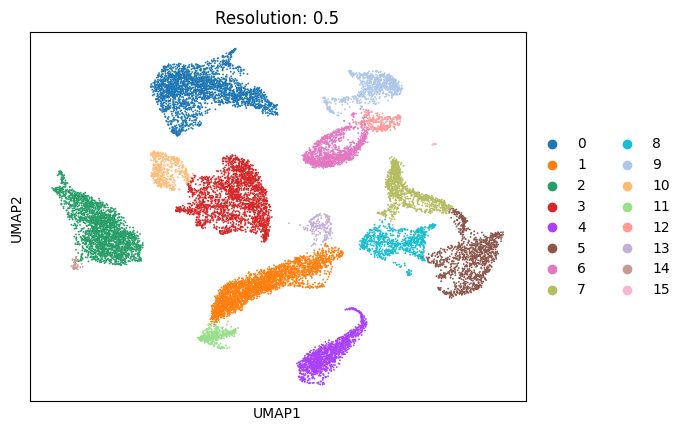

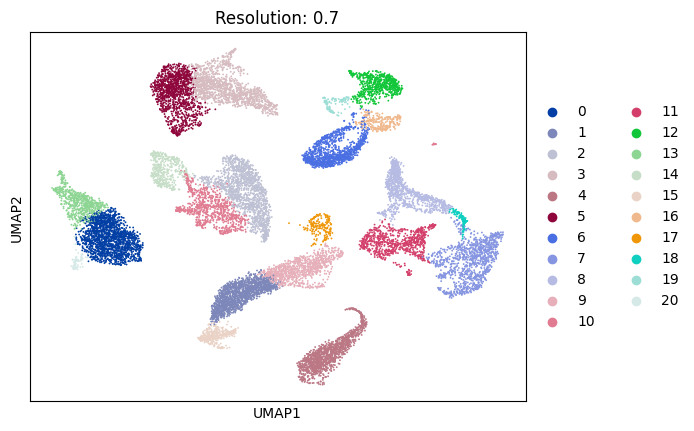

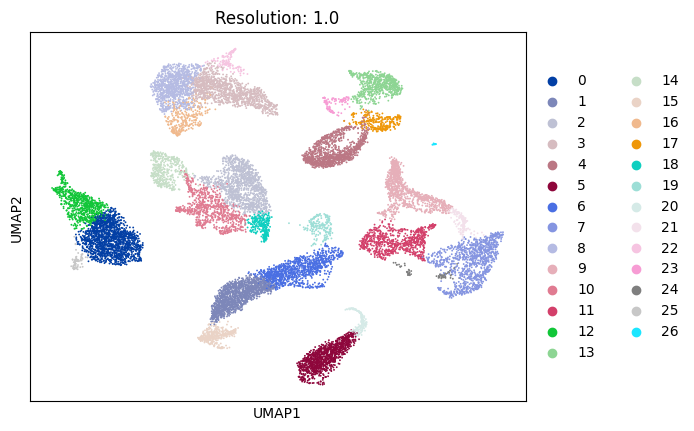

In [56]:
# Step4:. Clustering Parameter Sweep - When we have slected the Clustering method than we can optimize ressolution parameter
for resolution in [0.1, 0.3, 0.5, 0.7, 1.0]:
    sc.tl.leiden(combined_ad, resolution=resolution)
    sc.pl.umap(combined_ad, color='leiden', title=f'Resolution: {resolution}')

Silhouette Score: 0.4003507196903229


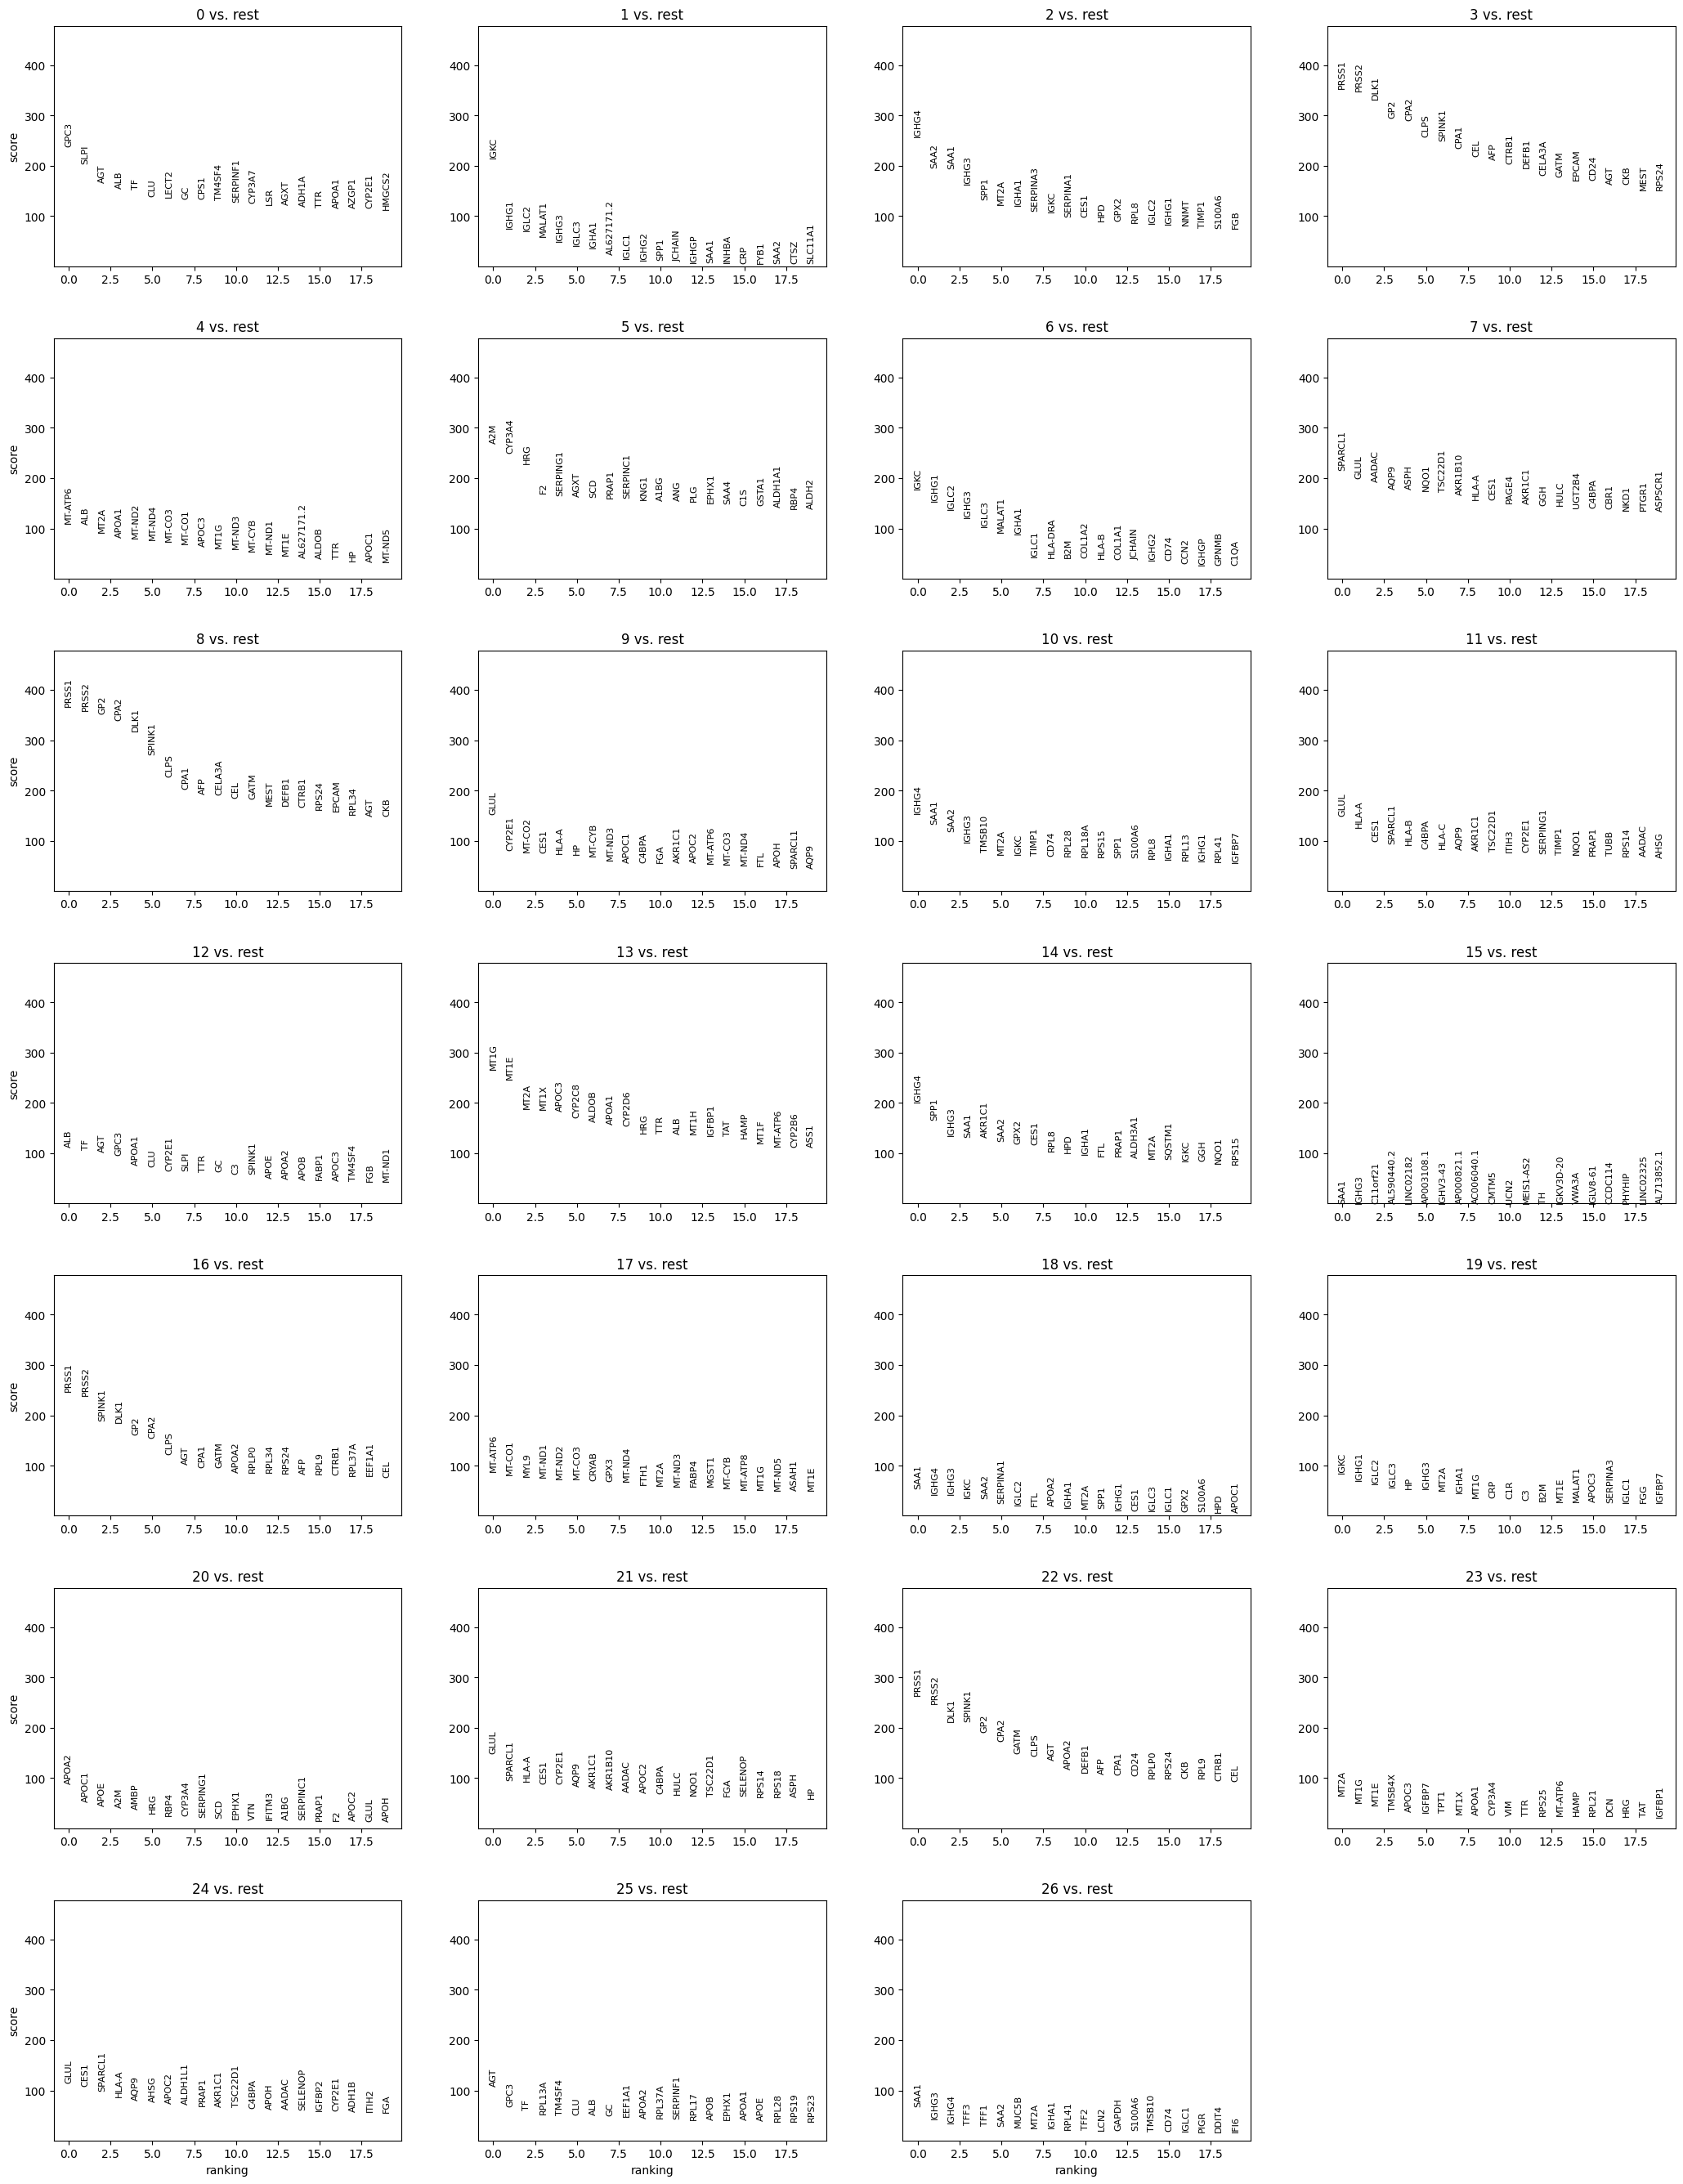

In [60]:
#5. Evaluate Cluster Quality
#a. Silhouette Score

#Quantify how well-separated clusters are using the silhouette score:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(combined_ad.obsm['X_umap'], combined_ad.obs['leiden'])
print(f"Silhouette Score: {silhouette_avg}")
#The silhouette score quantifies how well-separated clusters are by measuring the cohesion within clusters and separation between clusters, ranging from -1 (poor separation) to 1 (well-defined clusters)

#b. Marker Gene Identification
#Identify marker genes for each cluster:
sc.tl.rank_genes_groups(combined_ad, 'leiden', method='t-test')
sc.pl.rank_genes_groups(combined_ad)

#c. Functional Enrichment Analysis
#Perform enrichment analysis for cluster marker genes (e.g., Gene Ontology or KEGG pathways) using packages like gseapy.


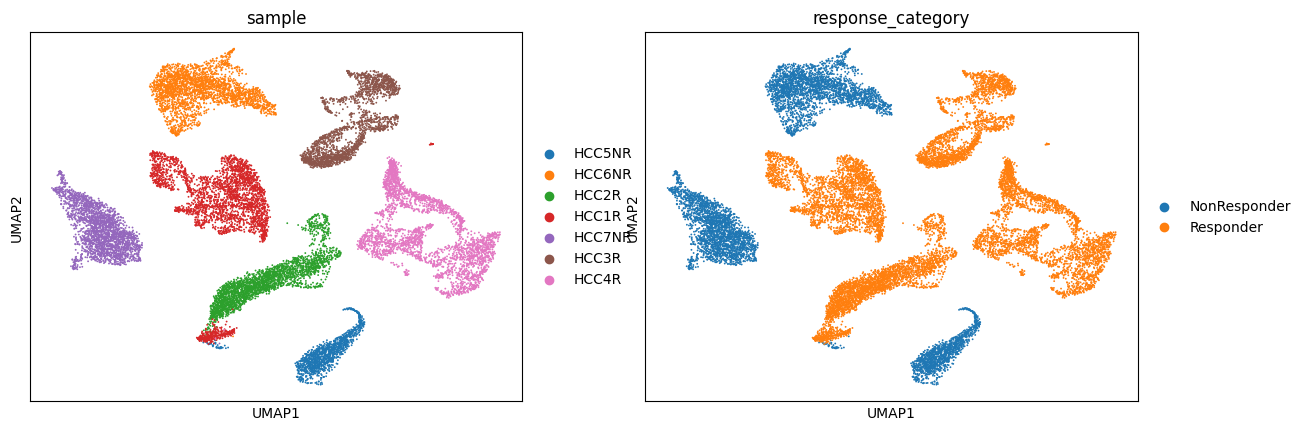

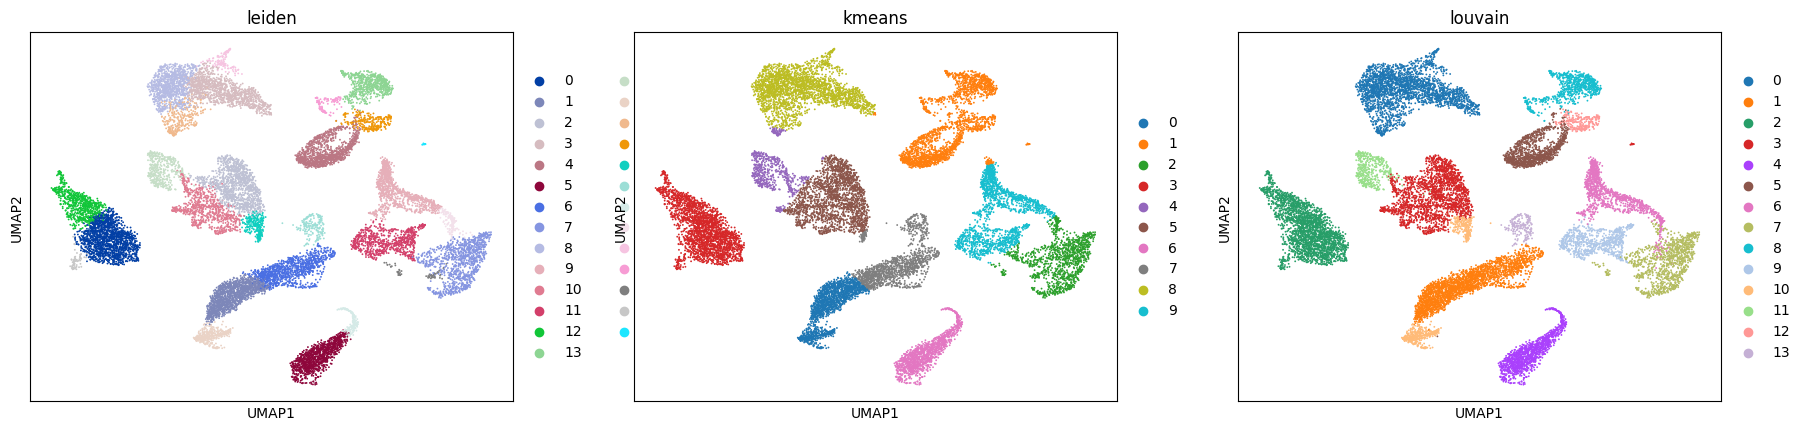

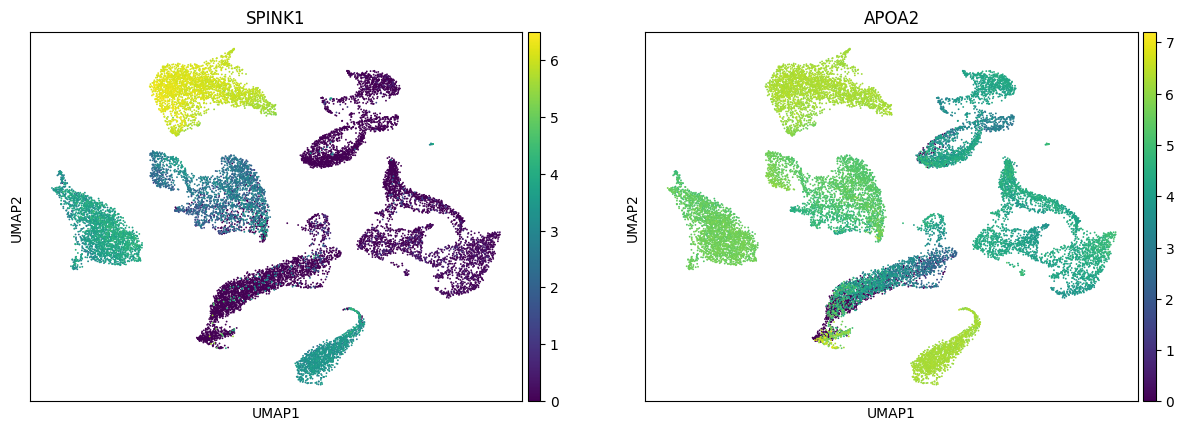

In [61]:
#6. Validate Biological Relevance
#a. Compare with Metadata
#Visualize how clusters relate to biological metadata (e.g., tissue type or disease status):
sc.pl.umap(combined_ad, color=['sample', 'response_category'])
sc.pl.umap(combined_ad, color=['leiden', 'kmeans', 'louvain'])

#b. Validate with Known Markers
#Overlay expression of known marker genes:

sc.pl.umap(combined_ad, color=['SPINK1', 'APOA2'], cmap='viridis')

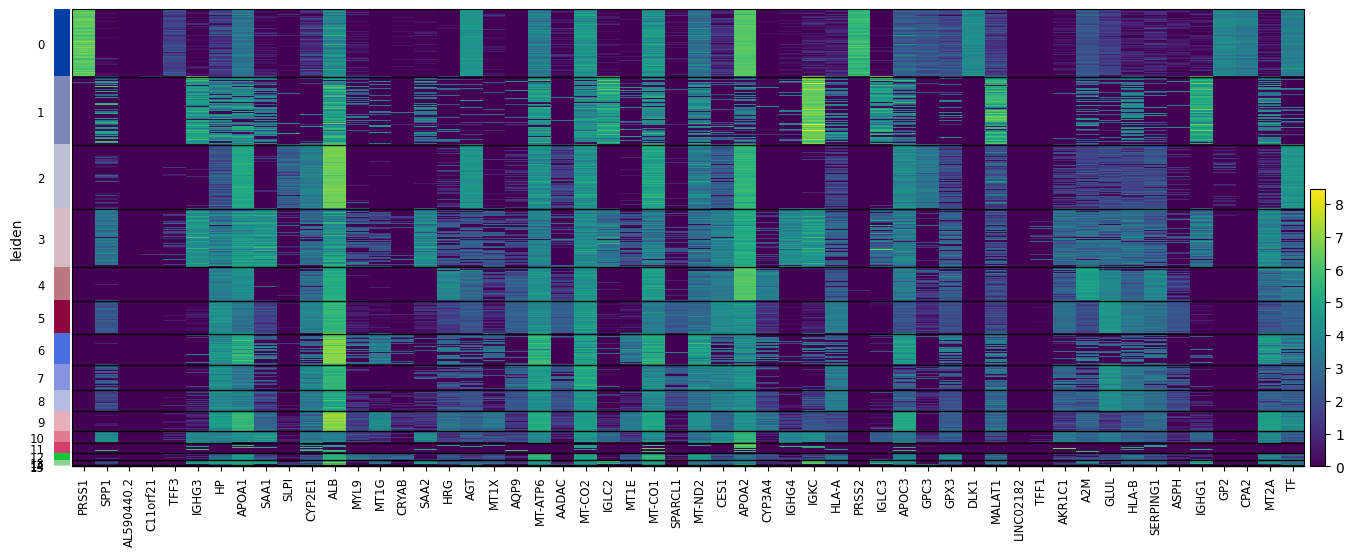

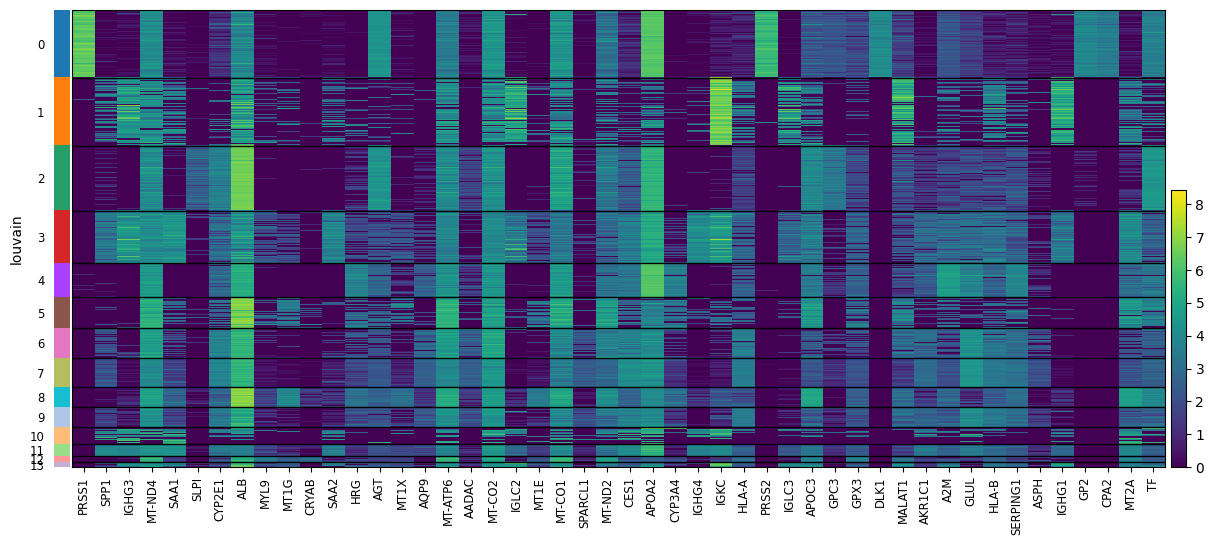

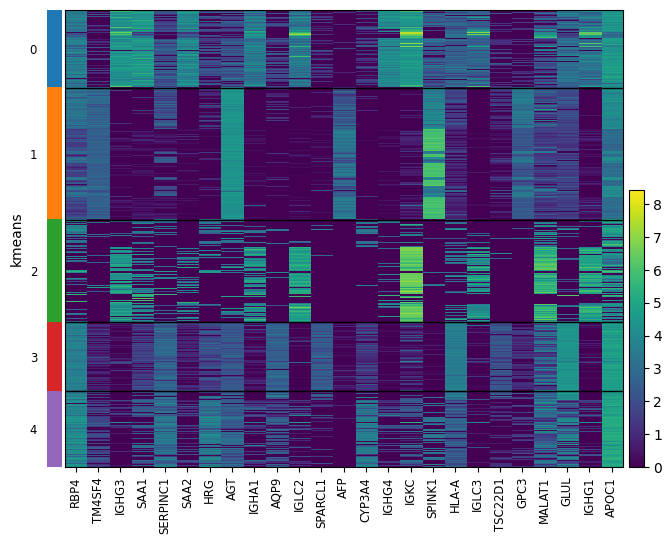

In [62]:
#7. Visualize and Report Results
#a. Generate Cluster Heatmap
#Display a heatmap of expression levels across clusters:

#sc.pl.heatmap(combined_ad, var_names=combined_ad.var_names[:25], groupby='leiden')
#sc.pl.heatmap(combined_ad, var_names=combined_ad.var_names[:25], groupby='louvain')
#sc.pl.heatmap(combined_ad, var_names=combined_ad.var_names[:25], groupby='kmeans')

## Option 2: 
#sc.tl.rank_genes_groups(combined_ad, groupby='leiden', method='t-test')  # Or method='wilcoxon'
#top_5_genes = []
#for cluster in combined_ad.obs['leiden'].unique():
#    genes = combined_ad.uns['rank_genes_groups']['names'][cluster][:5]
#    top_5_genes.extend(genes)
## Remove duplicates
#top_5_genes = list(set(top_5_genes))

#sc.pl.heatmap(
#    combined_ad, 
#    var_names=top_5_genes, 
#    groupby='leiden',
#    cmap='viridis', 
#    show_gene_labels=True
#)

import matplotlib.pyplot as plt

# List of clustering algorithms
clustering_algorithms = ['leiden', 'louvain', 'kmeans']  # Add more if needed

# Dictionary to store top marker genes for each algorithm
top_genes_dict = {}

# Loop over clustering algorithms
for algorithm in clustering_algorithms:
    # Perform clustering
    if algorithm == 'leiden':
        sc.tl.leiden(combined_ad, resolution=0.5)
    elif algorithm == 'louvain':
        sc.tl.louvain(combined_ad, resolution=0.5)
    elif algorithm == 'kmeans':
        from sklearn.cluster import KMeans
        n_clusters = 5  # Choose the desired number of clusters
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        combined_ad.obs['kmeans'] = kmeans.fit_predict(combined_ad.obsm['X_pca']).astype(str)
    
    # Perform differential expression analysis
    sc.tl.rank_genes_groups(combined_ad, groupby=algorithm, method='t-test')  # Or method='wilcoxon'
    
    # Extract top 5 marker genes
    top_genes = []
    for cluster in combined_ad.obs[algorithm].unique():
        genes = combined_ad.uns['rank_genes_groups']['names'][cluster][:5]
        top_genes.extend(genes)
    
    # Remove duplicates and store results
    top_genes_dict[algorithm] = list(set(top_genes))
    
    # Plot heatmap
    sc.pl.heatmap(
        combined_ad,
        var_names=top_genes_dict[algorithm],
        groupby=algorithm,
        cmap='viridis',
        show_gene_labels=True
    )
    
    # Set the title using matplotlib
    #plt.title(f"Heatmap for {algorithm}")
    plt.show()  # Ensure the plot is displayed

In [63]:
#b. Save Results
#Save clustering results for downstream use:
combined_ad.write('data/Exercise_Clustering.h5ad')